In [16]:
import numpy as np
import pandas as pd
import yaml
import torch
import scanpy as sc
import scvi
import scib 
from scarches.models.scpoli import scPoli

from scib_metrics.benchmark import Benchmarker

from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics

from celldreamer.paths import DATA_DIR

from celldreamer.models.fm.ode import torch_wrapper
from tqdm import tqdm 
from pathlib import Path

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [17]:
adata = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'c_elegans' / 'c_elegans.h5ad')

In [18]:
# adata.layers["X_counts"] = adata.layers["X_counts"].A
# adata.layers["X_counts"] = adata.layers["X_counts"].astype(np.float64)
# adata.X = adata.layers["X_counts"].copy()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


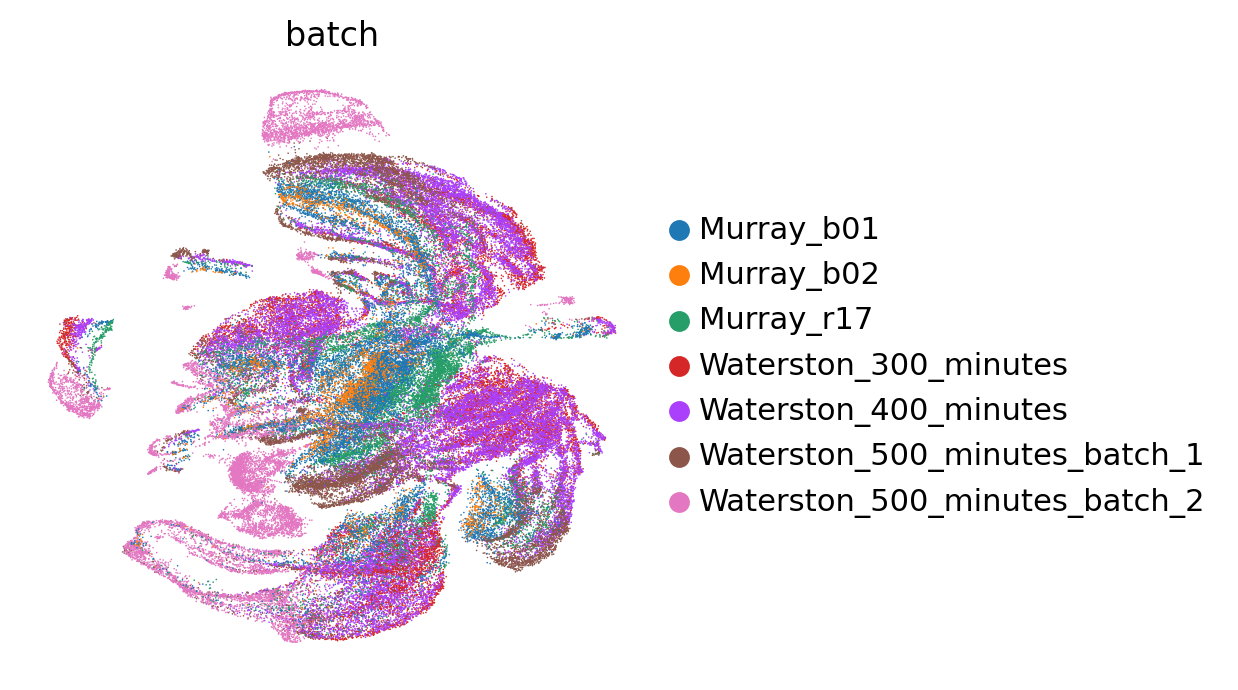

In [19]:
sc.pl.umap(adata, color="batch")

# scVI

In [20]:
scvi.model.SCVI.setup_anndata(adata, layer="X_counts", batch_key="batch")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [21]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=10, gene_likelihood="nb")

In [7]:
# model.train(max_epochs=100)

In [22]:
model = scvi.model.SCVI.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_model_celegans/",
                             adata)

INFO     File                                                                                                      
         /home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_mod
         el_celegans/model.pt already downloaded                                                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [23]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [24]:
# model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_model_celegans")

In [25]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)

In [26]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


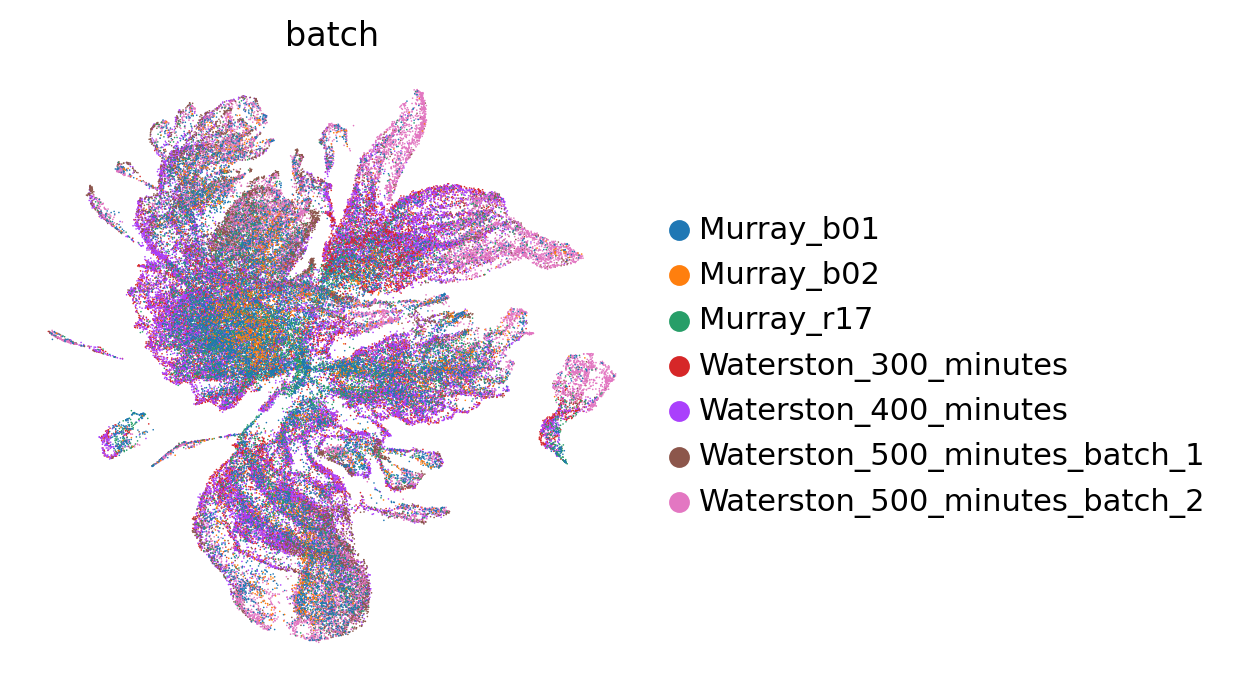

In [27]:
sc.pl.umap(adata, color="batch")

# scanVI

In [28]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown"
)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [8]:
# scanvi_model.train(max_epochs=100, batch_size=256, early_stopping=True)

INFO     Training for 100 epochs.                                                                                  


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/pyt

Epoch 100/100: 100%|██████████| 100/100 [31:58<00:00, 19.25s/it, v_num=1, train_loss_step=2.87e+3, train_loss_epoch=2.88e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [31:58<00:00, 19.18s/it, v_num=1, train_loss_step=2.87e+3, train_loss_epoch=2.88e+3]


In [29]:
scanvi_model = scvi.model.SCANVI.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_model_celegans",
                             adata)

INFO     File                                                                                                      
         /home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_m
         odel_celegans/model.pt already downloaded                                                                 


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [30]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [31]:
# scanvi_model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_model_celegans")

In [32]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)

In [33]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


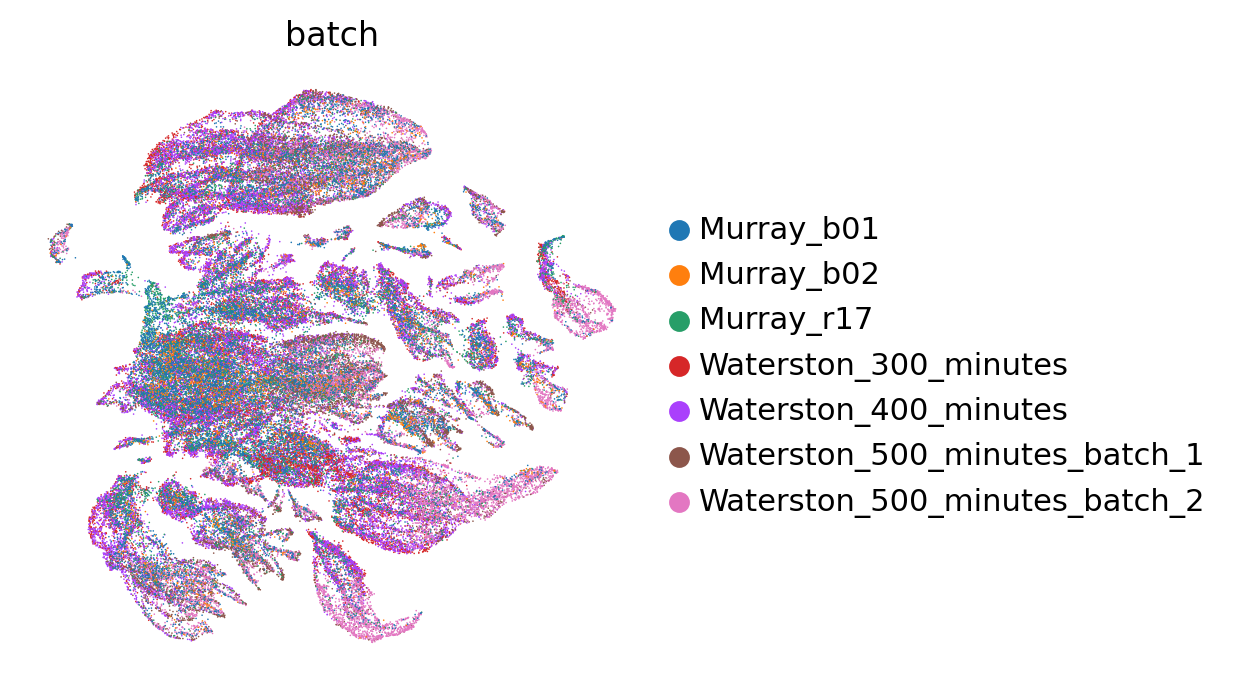

In [34]:
sc.pl.umap(adata, color="batch")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


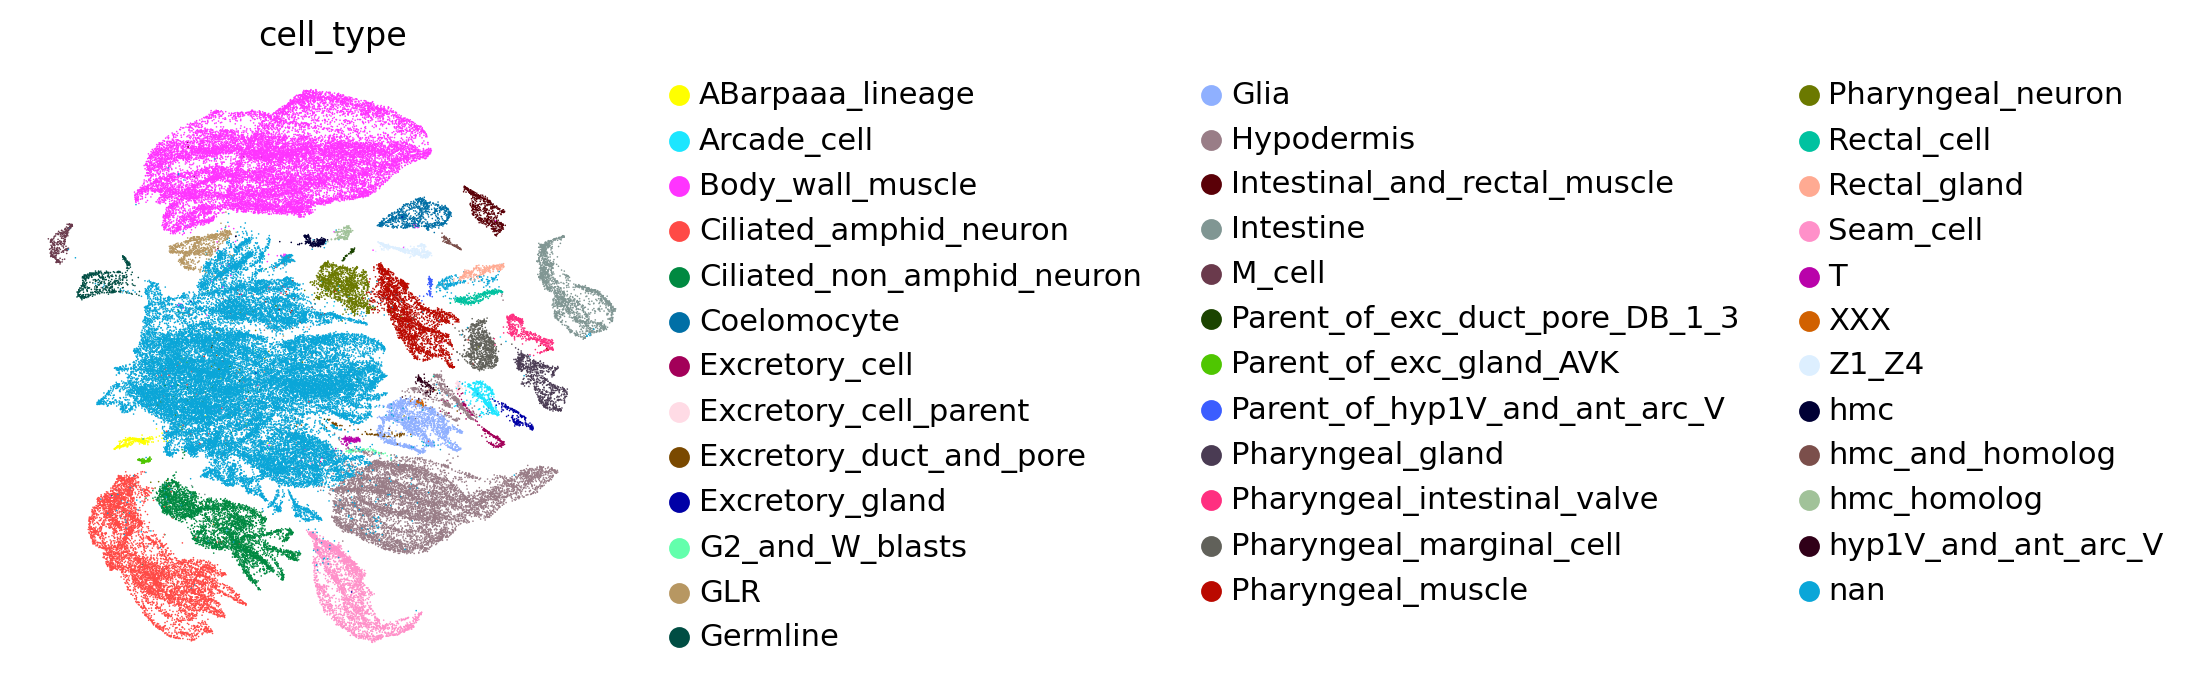

In [35]:
sc.pl.umap(adata, color="cell_type")

# scPoli

In [36]:
scpoli_model = scPoli(adata=adata,
                        condition_keys="batch",
                        cell_type_keys="cell_type",
                        embedding_dims=10,
                        latent_dim=50,
                        recon_loss='nb',
                    )
# scpoli_model.train(
#     n_epochs=100,
#     pretraining_epochs=40
# )

Embedding dictionary:
 	Num conditions: [7]
 	Embedding dim: [10]
Encoder Architecture:
	Input Layer in, out and cond: 17747 134 10
	Mean/Var Layer in/out: 134 50
Decoder Architecture:
	First Layer in, out and cond:  50 134 10
	Output Layer in/out:  134 17747 



In [38]:
scpoli_model.model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scpoli_model_celegans/model_params.pt"))

<All keys matched successfully>

In [39]:
# scpoli_model.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scpoli_model_neurips/", 
#                    )

In [40]:
#get latent representation of reference data
scpoli_model.model.eval()
data_latent = scpoli_model.get_latent(
    adata,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata.obs.copy()
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  c = torch.tensor(label_tensor, device=device).T


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


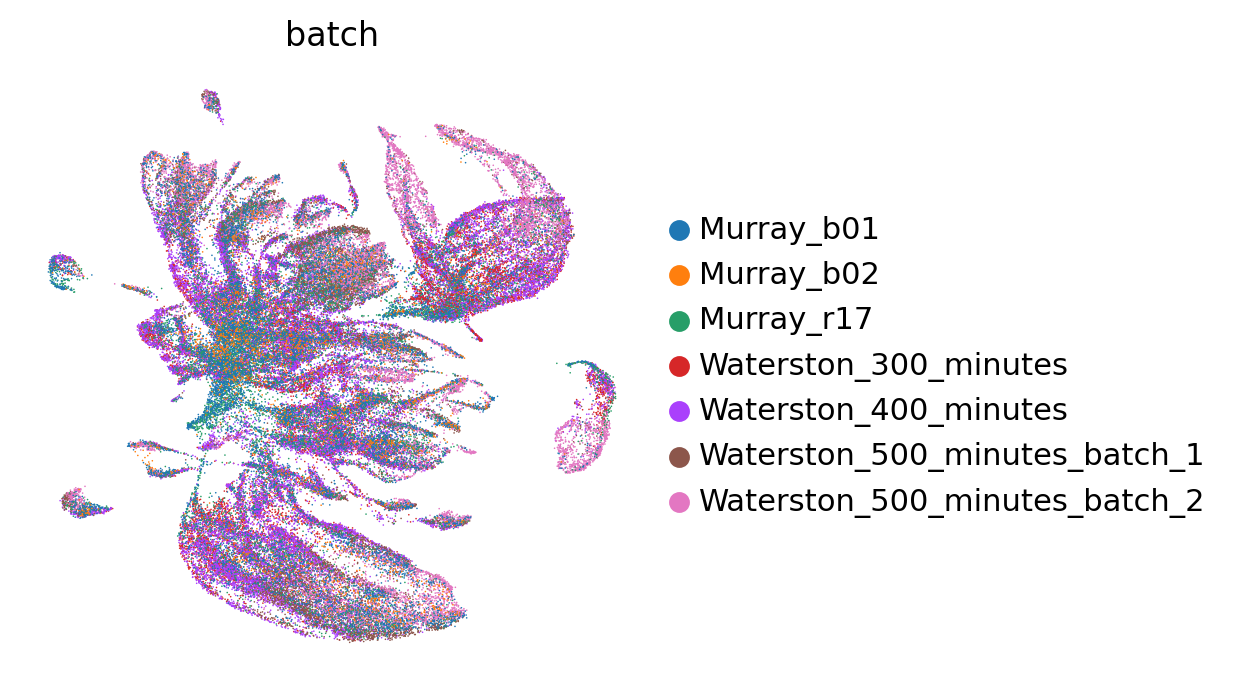

In [41]:
sc.pl.umap(adata_latent, color="batch")

In [42]:
adata.obsm["X_scpoli"] = data_latent

In [43]:
# scpoli_model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scpoli_model_celegans")

# Read cellFlow corrected dataset

In [44]:
adata_corrected_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/c_elegans_batch_correction/adata_corrected.h5ad")

In [45]:
# adata_corrected_decoded_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/celegans_batch_correction/adata_corrected_decoded.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


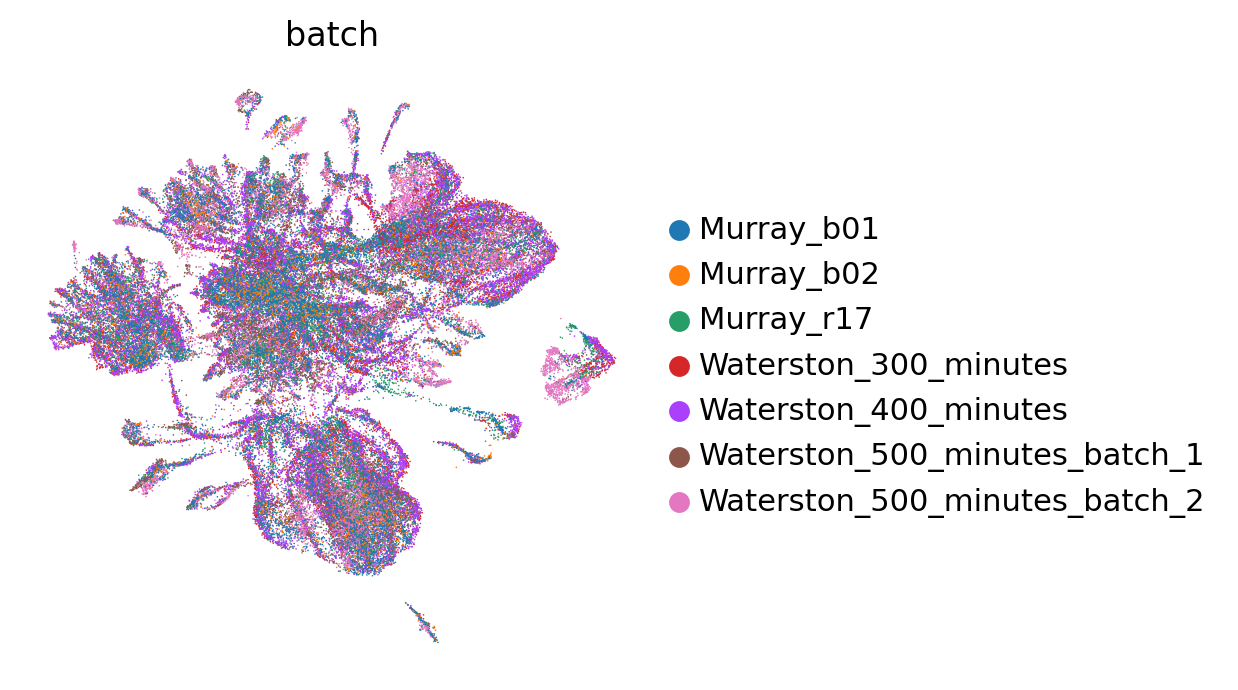

In [46]:
sc.pl.umap(adata_corrected_cellflow, color="batch")

In [47]:
adata.obsm["X_cellFlow"] = adata_corrected_cellflow.X.copy().astype(np.float32)

In [48]:
# adata.obsm["X_cellFlow"] = 

In [49]:
adata_corrected_cellflow.X.copy().shape

(89701, 100)

# Compute metrics

In [50]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY, "X_scpoli", "X_cellFlow"],
    n_jobs=-1,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|██████████| 5/5 [1:04:41<00:00, 776.37s/it]h correction: pcr_comparison]

                                                                                         

In [51]:
import pickle as pkl 

with open("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration_celegans.pkl", "wb") as file:
    pkl.dump(bm, file)

# with open("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration_celegans.pkl", "rb") as file:
#     bm = pkl.load(file)

In [52]:
bm._results.columns = ['Uncorrected', 'scVI', 'scANVI', "scPoli", 'cellFlow', 'Metric Type']

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


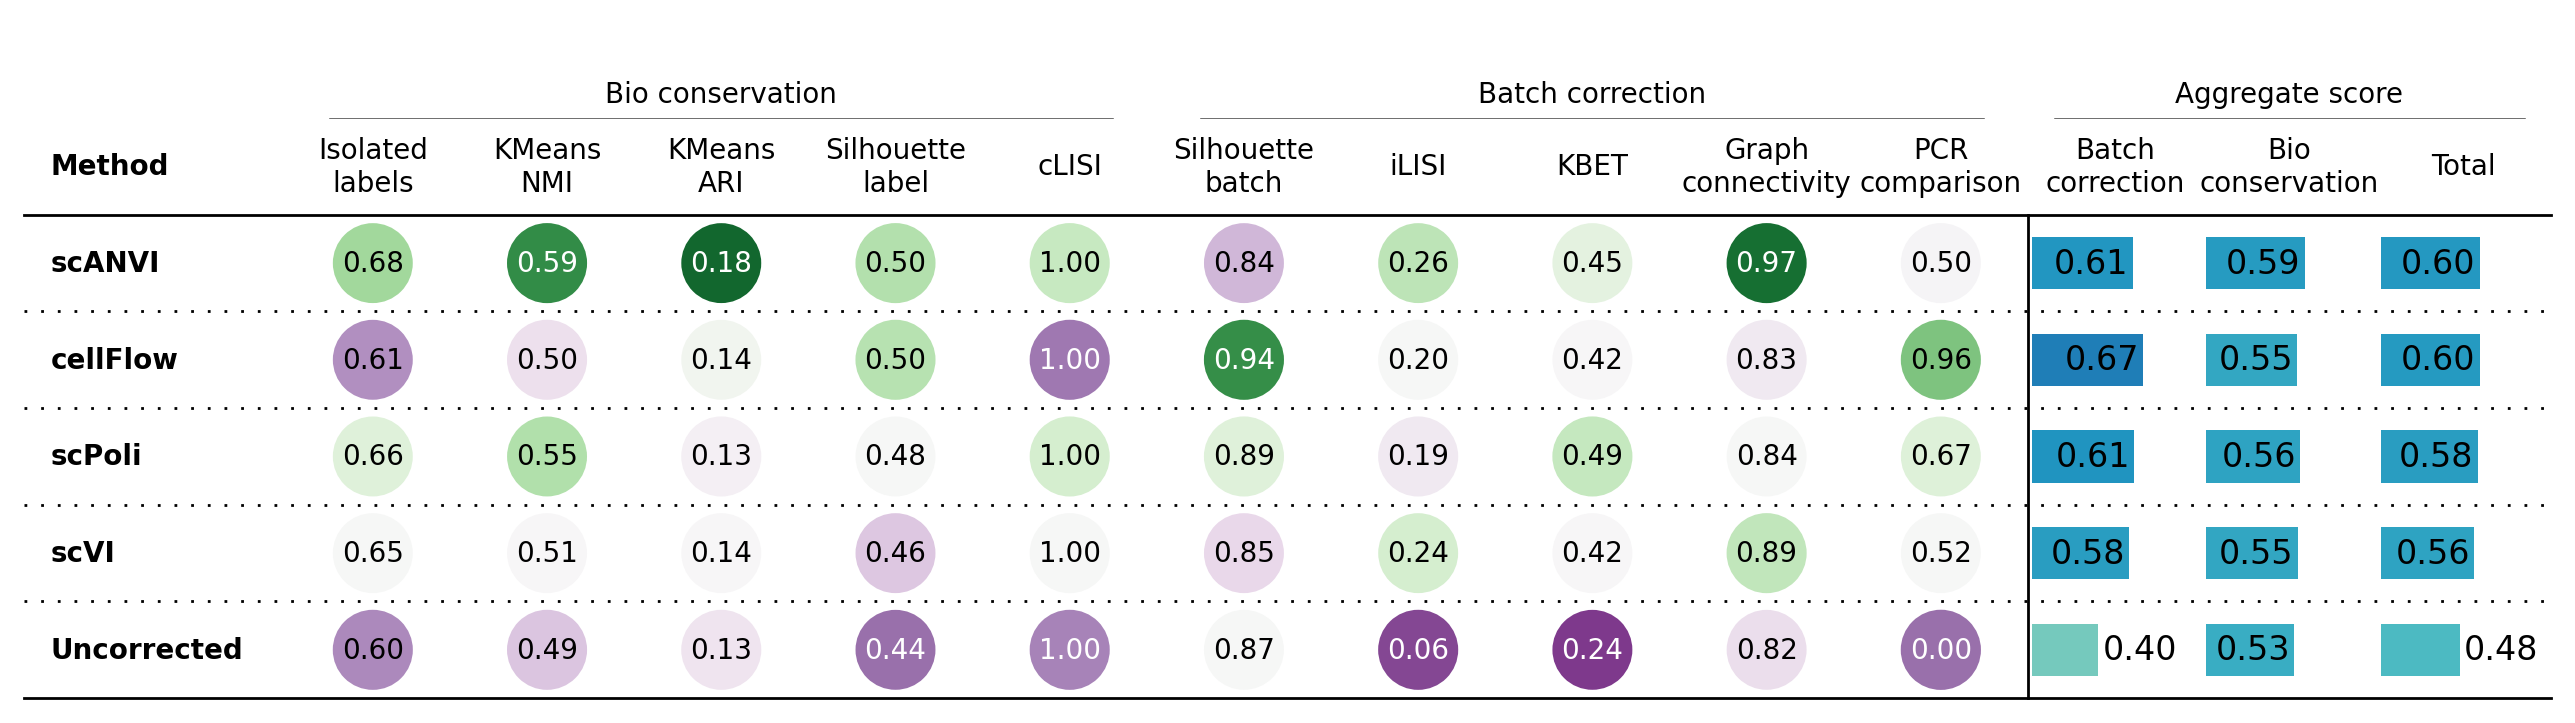

In [53]:
bm.plot_results_table(min_max_scale=False)

In [54]:
# df = bm.get_results(min_max_scale=False)
# df.to_csv("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.csv")

In [55]:
df = bm.get_results(min_max_scale=False)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [56]:
df

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
Uncorrected          0.603543          0.485943          0.129373   
scVI                 0.647446           0.51491          0.135149   
scANVI               0.683146          0.593815          0.183704   
scPoli               0.661267          0.553799          0.132643   
cellFlow             0.605376          0.500551           0.13765   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
Uncorrected          0.435748          0.999471          0.870935   
scVI                 0.459185          0.999823          0.853514   
scANVI               0.500729               1.0          0.839594   
scPoli                0.47685          0.999963          0.886363   
cellFlow               0.4997          0.999448          0.940089   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
Uncorrected          0.063011          0.238055           0.817782   
scVI                 0.244992          0.418604           0.886527   
scANVI               0.263306           0.45059           0.972315   
scPoli               0.186147          0.486421           0.840666   
cellFlow             0.203022          0.419607           0.828044   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
Uncorrected               0.0         0.397957         0.530816   
scVI                  0.52066         0.584859         0.551303   
scANVI               0.503824         0.605926         0.592279   
scPoli               0.668703          0.61366         0.564905   
cellFlow             0.962125         0.670577         0.548545   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
Uncorrected         0.477672  
scVI                0.564725  
scANVI              0.597738  
scPoli              0.584407  
cellFlow            0.597358  
Metric Type  Aggregate score

In [57]:
df.T.groupby("Metric Type").mean()

Embedding         Uncorrected      scVI    scANVI    scPoli  cellFlow
Metric Type                                                          
Aggregate score      0.468815  0.566962  0.598647  0.587657  0.605493
Batch correction     0.397957  0.584859  0.605926  0.613660  0.670577
Bio conservation     0.530816  0.551303  0.592279  0.564905  0.548545

In [58]:
df.T.groupby("Metric Type").std()/np.sqrt(5)

Embedding         Uncorrected      scVI    scANVI    scPoli  cellFlow
Metric Type                                                          
Aggregate score      0.029906  0.007553  0.003072  0.010974  0.027469
Batch correction     0.186559  0.124589  0.130534  0.128040  0.152320
Bio conservation     0.140914  0.140251  0.132252  0.140230  0.137853